# Import function

In [10]:
import numpy as np
# import awkward
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
import numpy as np
import scipy.optimize as opt
import sys, os, random, gzip
import tensorflow as tf
from keras import backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import Adam
from keras.losses import categorical_crossentropy
import pandas as pd

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from sklearn.model_selection import train_test_split
import sys
from sklearn import metrics
from keras.models import load_model
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import auc as skAUC
from keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, TensorBoard
import tensorflow as tf
from keras import backend as K
import time
import glob

In [12]:
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

def roc_plot(N, validation_split, model_name):
    dependencies = {'auc': auc}
    model = load_model(f'models/{model_name}.h5', custom_objects=dependencies)
    X_train, X_test, y_train, y_true = prep_data(N, validation_split)
    y_score=model.predict(X_test).T[0]  
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_score)
    bkg_eff = fpr
    sig_eff = tpr
    auc_val = roc_auc_score(y_true, y_score)
    bkg_rej = 1. - bkg_eff
    inv_bkg = np.divide(1.0, bkg_eff)
    print(model_name, auc_val)
    plt.plot(sig_eff, inv_bkg , linestyle='-', label=f'{model_name} - [AUC={auc_val:0.3}]', linewidth=2)
    plt.xlabel('Signal Efficiency')
    plt.yscale('log')
    plt.ylabel('Inverse Background Efficiency')
    plt.xlim([0,1])
    plt.legend()
    plt.savefig(f'figures/roc.png')
    
def prep_data(N, validation_split):
    f = h5py.File('data/jet_complete.h5', 'r')
    X = f['features'][:N]
    y = f['targets'][:N]
    X = np.log(1.0+X) / 4.0 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=validation_split)
    #reshape data to fit model
    X_train, X_test = X_train.reshape(len(X_train),32,32,1), X_test.reshape(len(X_test),32,32,1)
    return X_train, X_test, y_train, y_test

def train_nn(N, batch_size, epochs, validation_split):
    model_name = f'svj_N_{N}_b_{batch_size}_e_{epochs}_v_{validation_split}'
    X_train, X_test, y_train, y_test = prep_data(N, validation_split)
    #create model
    model = Sequential()
    #add model layers
    model.add(Conv2D(256, kernel_size=(4,4), border_mode='valid', init='glorot_normal', activation='relu', input_shape=(32,32,1)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, kernel_size=(4,4), border_mode='valid', init='glorot_normal', activation='relu'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    #compile model using accuracy to measure model performance
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[auc, 'acc'])

    mc = ModelCheckpoint(f'models/{model_name}.h5', monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto', period=1)
    cl = CSVLogger(f'history/{model_name}.log', separator=',', append=False)
    tb = TensorBoard(log_dir='./logs/'+ str(model_name), histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None, update_freq='epoch')
    #es = EarlyStopping(monitor='val_loss', min_delta=0, patience=25, verbose=0, mode='auto', baseline=None, restore_best_weights=False)


    #train the model
    model.fit(X_train, y_train, 
                batch_size=batch_size, 
                epochs=epochs, 
                verbose=2, 
                #validation_split=validation_split,
                validation_data=(X_test, y_test),
                callbacks=[cl, tb]
                )
    model.save(f'models/{model_name}.h5') 


if __name__ == "__main__":    
    #train_nn(N=500000, batch_size=256, epochs=500, validation_split=0.2)
    files = glob.glob('models/svj_*')
    for file in files:
        model_name = file.split('/')[-1].split('.h5')[0]
        details = model_name.split('_')    
        roc_plot(int(details[2]), float(details[-1]), model_name)

# Load data CNN

In [60]:
# f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0jetim.h5",'r')
# f = f['jetim'][()]
# f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0jetim.h5",'r')
# f2 = f2['jetim'][()]
f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0JSS_Jim.h5",'r')
f = f['Jet_im_my'][()]
f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0JSS_Jim.h5",'r')
f2 = f2['Jet_im_my'][()]

In [61]:
ft = np.append(f,f2, axis=0)

In [62]:
sum([1 for i in ft if np.sum(i)==0])

0

In [63]:
ft[0].shape

(64, 64)

In [64]:
yt = np.array([1 for i in range(len(f))]+[0 for i in range(len(f2))])

In [65]:
from sklearn.model_selection import train_test_split
Xim_train, Xim_val, yim_train, yim_val = train_test_split(ft, yt, test_size=0.3)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  


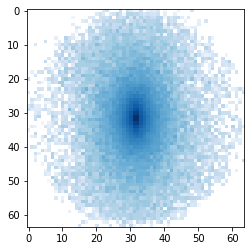

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


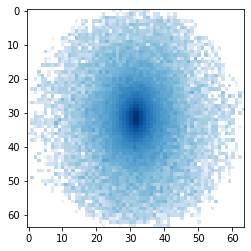

In [66]:
X = np.sum(f2, axis=0)
plt.imshow(np.log(X), cmap='Blues', label = 'QCD', filternorm=1)
plt.show()
Y = np.sum(f, axis=0)
plt.imshow(np.log(Y), cmap='Blues', label = 'SVJ', filternorm=1)
plt.show()

# Model CNN

In [67]:
inputs = tf.keras.Input(shape=(64,64))
x = inputs
x = tf.expand_dims(x,axis=-1)
x = tf.keras.layers.Conv2D(256, kernel_size=(4,4), activation='relu', input_shape=(64,64,1))(x)
x = tf.keras.layers.MaxPooling2D()(x)
x = tf.keras.layers.Conv2D(256, kernel_size=(4,4), activation='relu')(x)
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(2)(x)
modelCNN = tf.keras.Model(inputs=inputs, outputs=x, name='CNN')

In [68]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
modelCNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
modelCNN.summary()

Model: "CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 64, 64)]          0         
_________________________________________________________________
tf_op_layer_ExpandDims_5 (Te [(None, 64, 64, 1)]       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 61, 61, 256)       4352      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 27, 27, 256)       1048832   
_________________________________________________________________
flatten_5 (Flatten)          (None, 186624)            0         
_________________________________________________________________
dense_13 (Dense)             (None, 128)               23888000

In [69]:
modelCNN.fit(Xim_train, yim_train, batch_size=500 , validation_data=(Xim_val, yim_val), shuffle=True , epochs=20)

Epoch 1/20
15/15 [==============================] - 3s 185ms/step - loss: 2.2865 - accuracy: 0.6320 - val_loss: 0.6743 - val_accuracy: 0.6570
Epoch 2/20
15/15 [==============================] - 3s 176ms/step - loss: 0.6467 - accuracy: 0.6593 - val_loss: 0.6339 - val_accuracy: 0.6570
Epoch 3/20
15/15 [==============================] - 3s 176ms/step - loss: 0.6341 - accuracy: 0.6593 - val_loss: 0.6317 - val_accuracy: 0.6570
Epoch 4/20
15/15 [==============================] - 3s 176ms/step - loss: 0.6271 - accuracy: 0.6593 - val_loss: 0.6244 - val_accuracy: 0.6570
Epoch 5/20
15/15 [==============================] - 3s 177ms/step - loss: 0.6174 - accuracy: 0.6608 - val_loss: 0.6108 - val_accuracy: 0.6690
Epoch 6/20
15/15 [==============================] - 3s 176ms/step - loss: 0.6009 - accuracy: 0.6780 - val_loss: 0.6029 - val_accuracy: 0.6793
Epoch 7/20
15/15 [==============================] - 3s 177ms/step - loss: 0.5902 - accuracy: 0.6910 - val_loss: 0.6052 - val_accuracy: 0.6617
Epoch 

# Load data DNN

In [47]:
f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0JSS_Jim.h5",'r')
f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0JSS_Jim.h5",'r')


In [48]:
Labels = ['T21', 'D21', 'MASS', 'D22', 'C22', 'C21']

In [49]:
f = np.array([ f[i][()] for i in Labels])
f2 = np.array([ f2[i][()] for i in Labels])

In [50]:
f = f.transpose((1,0))
f2 = f2.transpose((1,0))

In [53]:
ft = np.append(f,f2, axis=0)

In [54]:
yt = np.array([1 for i in range(len(f))]+[0 for i in range(len(f2))])

In [55]:
ft[0].shape

(6,)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(ft, yt, test_size=0.3)

# Model DNN

In [57]:
inputs = tf.keras.Input(shape=(6,))
x = inputs
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(2)(x)
modelDNN = tf.keras.Model(inputs=inputs, outputs=x, name='DNN')

In [58]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
modelDNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
modelDNN.summary()

Model: "DNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               1792      
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 258       
Total params: 34,946
Trainable params: 34,946
Non-trainable params: 0
_________________________________________________________________


In [59]:
modelDNN.fit(X_train, y_train, batch_size=500 , validation_data=(X_val, y_val), shuffle=True , epochs=20)

Epoch 1/20
15/15 [==============================] - 0s 12ms/step - loss: 1.9661 - accuracy: 0.5492 - val_loss: 0.7238 - val_accuracy: 0.5771
Epoch 2/20
15/15 [==============================] - 0s 7ms/step - loss: 1.2441 - accuracy: 0.5924 - val_loss: 0.8481 - val_accuracy: 0.6637
Epoch 3/20
15/15 [==============================] - 0s 7ms/step - loss: 1.0860 - accuracy: 0.5934 - val_loss: 0.6944 - val_accuracy: 0.6637
Epoch 4/20
15/15 [==============================] - 0s 8ms/step - loss: 0.9654 - accuracy: 0.5930 - val_loss: 0.6304 - val_accuracy: 0.6139
Epoch 5/20
15/15 [==============================] - 0s 7ms/step - loss: 0.8543 - accuracy: 0.6003 - val_loss: 0.6756 - val_accuracy: 0.5765
Epoch 6/20
15/15 [==============================] - 0s 7ms/step - loss: 0.8445 - accuracy: 0.6028 - val_loss: 0.6589 - val_accuracy: 0.6637
Epoch 7/20
15/15 [==============================] - 0s 7ms/step - loss: 0.7772 - accuracy: 0.6082 - val_loss: 0.6153 - val_accuracy: 0.6610
Epoch 8/20
15/15 [=

In [54]:
len(y_train)

27879

# Load 2CNN data

In [76]:
f = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/SVJ/0JSS_Jim.h5",'r')
f2 = h5py.File("/home/ja2006203966/script/Network/data/Mydata/H5/QCD/0JSS_Jim.h5",'r')
fim = f['Jet_im_my'][()]
fim2 = f2['Jet_im_my'][()]

In [77]:
Labels = ['T21', 'D21', 'MASS', 'D22', 'C22', 'C21']

In [78]:
f = np.array([ f[i][()] for i in Labels])
f2 = np.array([ f2[i][()] for i in Labels])

In [79]:
f = f.transpose((1,0))
f2 = f2.transpose((1,0))

In [84]:
ft = np.append(f,f2, axis=0)
ftim = np.append(fim,fim2, axis=0)

In [85]:
yt = np.array([1 for i in range(len(f))]+[0 for i in range(len(f2))])

In [94]:
# fc = (ft,ftim)

In [95]:
fc = np.array([(ft[i],ftim[i]) for i in range(len(ft))])

In [99]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(fc, yt, test_size=0.3)

In [110]:
X_train1 = X_train.transpose(1,0)[0]
X_train2 = X_train.transpose(1,0)[1]
X_val1 = X_val.transpose(1,0)[0]
X_val2 = X_val.transpose(1,0)[1]

In [114]:
X_train1 = np.array([i for i in X_train1])
X_train2 = np.array([i for i in X_train2])
X_val1 = np.array([i for i in X_val1])
X_val2 = np.array([i for i in X_val2])

# Model 2CNN

In [116]:
inputs = tf.keras.Input(shape=(6,))
x = inputs
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(1)(x)

inputs2 = tf.keras.Input(shape=(64,64))
x2 = inputs2
x2 = tf.expand_dims(x2,axis=-1)
x2 = tf.keras.layers.Conv2D(256, kernel_size=(4,4), activation='relu', input_shape=(64,64,1))(x2)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.Conv2D(256, kernel_size=(4,4), activation='relu')(x2)
x2 = tf.keras.layers.Flatten()(x2)
# x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

x2 = tf.keras.layers.Dense(128, activation='relu')(x2)
x2 = tf.keras.layers.Dropout(0.2)(x2)
x2 = tf.keras.layers.Dense(1)(x2)

xt = tf.concat([x,x2], axis=-1)
xt = tf.keras.layers.Dense(128, activation='relu')(xt)
xt = tf.keras.layers.Dropout(0.2)(xt)
xt = tf.keras.layers.Dense(2, activation='sigmoid')(xt)




model2CNN = tf.keras.Model(inputs=(inputs, inputs2), outputs=xt, name='2CNN')

In [117]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model2CNN.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])
model2CNN.summary()

Model: "2CNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 64, 64)]     0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims_10 (Tens [(None, 64, 64, 1)]  0           input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_20 (Conv2D)              (None, 61, 61, 256)  4352        tf_op_layer_ExpandDims_10[0][0]  
__________________________________________________________________________________________________
max_pooling2d_10 (MaxPooling2D) (None, 30, 30, 256)  0           conv2d_20[0][0]                  
_______________________________________________________________________________________________

In [118]:
model2CNN.fit((X_train1,X_train2), y_train, batch_size=500 , validation_data=((X_val1,X_val2), y_val), shuffle=True , epochs=20)

Epoch 1/20
15/15 [==============================] - 3s 189ms/step - loss: 0.6569 - accuracy: 0.6455 - val_loss: 0.6390 - val_accuracy: 0.6693
Epoch 2/20
15/15 [==============================] - 3s 179ms/step - loss: 0.6454 - accuracy: 0.6536 - val_loss: 0.6287 - val_accuracy: 0.6693
Epoch 3/20
15/15 [==============================] - 3s 179ms/step - loss: 0.6436 - accuracy: 0.6547 - val_loss: 0.6393 - val_accuracy: 0.6693
Epoch 4/20
15/15 [==============================] - 3s 178ms/step - loss: 0.6469 - accuracy: 0.6540 - val_loss: 0.6379 - val_accuracy: 0.6693
Epoch 5/20
15/15 [==============================] - 3s 178ms/step - loss: 0.6407 - accuracy: 0.6542 - val_loss: 0.6329 - val_accuracy: 0.6693
Epoch 6/20
15/15 [==============================] - 3s 180ms/step - loss: 0.6275 - accuracy: 0.6522 - val_loss: 0.6405 - val_accuracy: 0.6693
Epoch 7/20
15/15 [==============================] - 3s 178ms/step - loss: 0.6263 - accuracy: 0.6532 - val_loss: 0.6290 - val_accuracy: 0.6693
Epoch 

# Back up

In [ ]:
# y_test=[i[1] for i in testpojen_datay]
X_test = np.load("./X_test.npy",allow_pickle=True)
X_test = X_test.item()
y_test = np.load("./y_test.npy",allow_pickle=True)
y_score=model.predict(X_test)[:,0]
test=[i[1] for i in y_test]
fpr , tpr , thresholds = roc_curve ( test , y_score)
roc_auc = auc(tpr,fpr )
print("The area under the curves are:")
print("AUC:{0:.9f}".format(roc_auc))
# FalsePositiveFull, TruePositiveFull, ThresholdFull = metrics.roc_curve(y_test,Predictions)
plt.figure(figsize=(8,16))
plt.subplot(2,1,1)

plt.plot(tpr,fpr, label='Fully supervised: AUC={0:.9f}'.format(roc_auc))
plt.ylabel('1-False Positive Rate',fontsize=20)
plt.xlabel('True Positive Rate',fontsize=20)
plt.plot([0, 1], [0, 1], 'k--')
plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
plt.tight_layout()
plt.savefig("./Myneighnorhood_Particlenet_roc.png")
np.save("./myfpr",fpr)
np.save("./mytpr",tpr)
#plt.close()
 
# plt.subplot(2,1,2) 
# LOSS = pd.read_csv('./training_log.csv')
# plt.plot(LOSS["loss"], label='loss',c='blue')
# plt.plot(LOSS["val_loss"], label='val_loss',c='red')
# plt.ylabel('loss',fontsize=20)
# plt.xlabel('epoch',fontsize=20)
# plt.legend(bbox_to_anchor=(0.8, -0.17),ncol=2)
# plt.tight_layout()

#plt.savefig("./plot_3.png")
#plt.close()
plt.show()

# Papaer's CNN

In [ ]:
def data_generator(h5file1, h5file2, batchsize, hlindices, start=0, stop=None):
    stop = ((stop-start) // batchsize) * batchsize + start
    assert (stop-start) % batchsize     == 0  # Batches will not exceed stop.

    with h5py.File(h5file1, 'r') as f1, h5py.File(h5file2, 'r') as f2:
        assert f1['features'].shape[0] >= stop
        assert f1['features'].shape[0] == f1['targets'].shape[0]
        assert f1['features'].shape[0] == f2['features'].shape[0]
        assert f1['targets'].shape[0] == f2['targets'].shape[0]
        iexample = start
        
        while True:
            assert iexample >= start
            assert iexample+batchsize <= stop
            batch = slice(iexample, iexample + batchsize)

            X  = f1['features'][batch] # Images.
            Y  = f1['targets'][batch]
            #X2 = f2['features'][batch][:, hlindices] # High-level.
            #Y2 = f2['targets'][batch]  
            #assert np.all(Y == Y2)
            
            X = np.log(1.0+X) / 4.0 
            
            #yield X, Y
            #yield {'input_0':X, 'input_1':X2}, {'output':Y}
            yield {'input_0':X}, {'output':Y}
            
            iexample += batchsize
            if iexample >= stop:
                assert iexample == stop
                iexample = start
    

def train():
    ###############################################################################
    # Dataset                                                                     #
    ###############################################################################
    #filename = '/home/pjsadows//ml/data/physics/jets/download4/datasets/train_no_pile_10000000.h5'
    hlindices = np.array(['mass', 'c1b1']) # Order of features: mass, c1b1,c2b2,d1b2,d2b2, tau

    #filename  = '/Volumes/Free Space/images/train_no_pile_10000000.h5'
    #filename2 = '/Volumes/Free Space/highlevel/train_no_pile_10000000.h5'

    filename  = './train2_no_pile_10000000.h5' #image input
    filename2 = './train_no_pile_10000000.h5' #high level features input

    N_train, N_valid = 9500000, 500000
    generator = data_generator(filename, filename2, batchsize=100, hlindices=hlindices, start=0, stop=N_train)
    validation_data = data_generator(filename, filename2, batchsize=100, hlindices=hlindices, start=N_train, stop=N_train+N_valid)

    #filename_test  = '/Volumes/Free Space/images/test_no_pile_5000000.h5'
    #filename2_test = '/Volumes/Free Space/highlevel/test_no_pile_5000000.h5'

    filename_test  = './test2_no_pile_5000000.h5'
    filename2_test = './test_no_pile_5000000.h5'

    N_test = 5000000
    generator_test = data_generator(filename_test, filename2_test, batchsize=100, hlindices=hlindices, start=0, stop=N_test)

    ###############################################################################
    # Model                                                                       #
    ###############################################################################
    act  = 'relu' 
    init = 'glorot_normal' #'glorot_normal'#'he_normal'
    width = 500 #500 
    # Image arm
    nconv  = 4
    nch    = 32
    # Head
    nhead = 4
    ndo   = 2 
    
    # Arm 0: images
    input_0 = Input(shape=(1,32,32), dtype='float32', name='input_0') # We can name an layer by passing name.
    x0 = input_0
    for i in range(nconv):
        x0 = Convolution2D(nch,1, subsample=(1,1), border_mode='valid', init=init, activation=act)(x0) # nch, 4, 4
    x0 = Flatten()(x0) 

    # Arm 1: high-level variables.
    #input_1  = Input(shape=(len(hlindices),), name='input_1')
    #x1 = input_1
    #for i in range(nhl):
    #    x1 = Dense(width, init=init, activation=act)(x1)

    # Head
    #x = merge([x0, x1], mode='concat')
    x = x0
    for i in range(nhead):
        x = Dense(width, activation=act, init=init)(x)
        if i >= nhead - ndo:
            x = Dropout(p=0.5)(x)
    output = Dense(1, activation='sigmoid', name='output')(x)

    # Model
    #model = Model(input=[input_0, input_1], output=[output])
    model = Model(input=[input_0], output=[output])
    lrinit  = 0.0001 
    lrdecay = 0.8
    optimizer = Adam(lr=lrinit, beta_1=0.99, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer,loss={'output':'binary_crossentropy'}, metrics=['accuracy'])

    ###############################################################################
    # Algorithm                                                                   #
    ###############################################################################
    def lr_scheduler(epoch):
        return lrinit * lrdecay ** epoch
    lrschedule = LearningRateScheduler(lr_scheduler)
    stopping   = EarlyStopping(monitor='val_loss', patience=0, verbose=0, mode='min') 
    cbks = [stopping, lrschedule]

    # Copy script so that we can reconstruct model later.
    filebase = './images_conv%d_dense%d_nch%d_do%d_width%d_%s_lrd%d_%d' % (nconv, nhead, nch, ndo, width, act, lrdecay*100, np.random.randint(1000))
    fileout = filebase + '.py'
    os.system('cp %s %s' % (filebase, fileout))
    print('Saving to %s' % fileout)
    
    # Train.
    nb_epoch  = 1000
    history = model.fit_generator(generator, samples_per_epoch=N_train, nb_epoch=nb_epoch, verbose=1, validation_data=validation_data, nb_val_samples=N_valid, class_weight=None, callbacks=cbks) 

    # Save model.
    fileout = filebase + '.h5'
    model.save_weights(fileout, overwrite=True)
    # Save pkl.
    fileout = filebase + '.pkl'
    with open(fileout, 'w') as f:
        pickle.dump(history.history, f)
    # Save .yaml script.
    fileout = filebase + '.yaml'
    with open(fileout, 'w') as f:
        f.write(model.to_yaml())

    # Compute test error accuracy.
    vals = model.evaluate_generator(generator_test, val_samples=N_test, max_q_size=10)
    for name, val in zip(model.metrics_names, vals):
        print('test_%s: %f' % (name, val))
        history.history['test_' + name] = val
    # Compute AUC
    #auc = compute_auc(model, generator_test, val_samples=N_test)
    #print 'Test AUC: %f' % auc
    #history.history['test_auc'] = auc

    # Save pkl.
    fileout = filebase + '.pkl'
    with open(fileout, 'w') as f:
        pickle.dump(history.history, f)


    return history.history['val_loss'][-1]

# if __name__=='__main__':
#     loss = train()
#     print(loss)
